# Fall 2022: DS-GA 1011 NLP with Representation Learning
## Homework 2
## Part 2: Neural Language Modeling (30 pts)
In this assignment, you will build and analyze a neural language model with a recurrent neural network.

In [ ]:
!pip install jsonlines

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import required packages
import os
import copy
import json
import jsonlines
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F
from torch.nn import LSTM
from torch.utils.data import Dataset, DataLoader

In [ ]:
# For colab users
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
sys.path.append("/content/drive/MyDrive/nlp/hw2")
sys.path.append("/content/drive/MyDrive/nlp/hw2/pyfiles")
sys.path

['/content',
 '/env/python',
 '/usr/lib/python37.zip',
 '/usr/lib/python3.7',
 '/usr/lib/python3.7/lib-dynload',
 '',
 '/usr/local/lib/python3.7/dist-packages',
 '/usr/lib/python3/dist-packages',
 '/usr/local/lib/python3.7/dist-packages/IPython/extensions',
 '/root/.ipython',
 '/content/drive/MyDrive/nlp/hw2',
 '/content/drive/MyDrive/nlp/hw2/pyfiles']

In [ ]:
cd /content/drive/MyDrive/nlp/hw2/

/content/drive/MyDrive/nlp/hw2


In [ ]:
ls

data/                      model_lstm_128.pt  pyfiles/
hw2-part1-bow_nli/         model_lstm_256.pt  wikitext2-sentencized.json
hw2-part2-nlm_zx657.ipynb  model_lstm_512.pt
hw2-part3-nmt_zx657.ipynb  model_lstm_64.pt


In [ ]:
# Import custom modules
from pyfiles import bleu_score
from pyfiles import global_variables
from pyfiles import nmt_dataset
from pyfiles import nnet_models_new

In [ ]:
#torch.cuda.is_available()
global_variables.device

device(type='cuda')

In [ ]:
num_gpus = torch.cuda.device_count()
if num_gpus > 0:
    current_device = 'cuda'
else:
    current_device = 'cpu'
current_device

'cuda'

---
### 1 LSTM and Hyper-parameters (10 pts)
Your first task is to train a neural recurrent language model on Wikitext-2.

#### Load data

In [ ]:
def load_wikitext(filename='wikitext2-sentencized.json'):
    if not os.path.exists(filename):
        !wget "https://nyu.box.com/shared/static/9kb7l7ci30hb6uahhbssjlq0kctr5ii4.json" -O $filename
    
    datasets = json.load(open(filename, 'r'))
    for name in datasets:
        datasets[name] = [x.split() for x in datasets[name]]
    vocab = list(set([t for ts in datasets['train'] for t in ts]))      
    print("Vocab size: %d" % (len(vocab)))
    return datasets, vocab

def perplexity(model, sequences):
    n_total = 0
    logp_total = 0
    for sequence in sequences:
        logp_total += model.sequence_logp(sequence)
        n_total += len(sequence) + 1  
    ppl = 2 ** (- (1.0 / n_total) * logp_total)  
    return ppl

In [ ]:
datasets, vocab = load_wikitext()

Vocab size: 33175


In [ ]:
len(datasets) # 3 - dict
datasets.keys() # dict_keys(['train', 'valid', 'test'])
len(datasets['train']) # 78274
len(datasets['train'][0]) # 30
len(vocab) # 33175 - list
vocab[0]

'Goo'

#### Utilities

(Hint: you can adopt the `Dictionary`, dataset loading, `Dataloader`, `pad_collate_fn`, and training code from the lab: [**07-rnn_lm.ipynb**](https://drive.google.com/file/d/1scqLM26Njy4ACL9zyIQEVcoP32eTN77i/view?usp=sharing) for use here)

In [ ]:
# function to map words to indices and returns a dictionary
class Dictionary(object): 
    def __init__(self, datasets, include_valid=False):
        self.tokens = []
        self.ids = {}
        self.counts = {}
        
        # add special tokens
        self.add_token('') #beginning of sentence
        self.add_token('') #end of sentence
        self.add_token('')
        self.add_token('') #unknown. Needed in case use with text with word that isn't in vocab
        
        for line in tqdm(datasets['train']):
            for w in line:
                self.add_token(w)
                    
        if include_valid is True:
            for line in tqdm(datasets['valid']):
                for w in line:
                    self.add_token(w)
                            
    def add_token(self, w):
        if w not in self.tokens:
            self.tokens.append(w)
            _w_id = len(self.tokens) - 1
            self.ids[w] = _w_id
            self.counts[w] = 1
        else:
            self.counts[w] += 1

    def get_id(self, w):
        return self.ids[w]
    
    def get_token(self, idx):
        return self.tokens[idx]
    
    def decode_idx_seq(self, l):
        return [self.tokens[i] for i in l]
    
    def encode_token_seq(self, l):
        return [self.ids[i] if i in self.ids else self.ids[''] for i in l]
    
    def __len__(self):
        return len(self.tokens)

In [ ]:
wiki_dict = Dictionary(datasets, include_valid = True)

100%|██████████| 8464/8464 [00:10<00:00, 802.07it/s]


In [ ]:
print(len(wiki_dict))
for i in range(10):
    print(i, wiki_dict.get_token(i))

33179
0 
1 Valkyria
2 of
3 the
4 Battlefield
5 3
6 )
7 ,
8 commonly
9 referred


In [ ]:
def tokenize_dataset(datasets, dictionary): #substitute words with numbers. Sometimes can include splitting strings, dealing with punctuation and symbols.
    tokenized_datasets = {}
    for split, dataset in datasets.items():
        _current_dictified = []
        for l in tqdm(dataset):
            l = [''] + l + ['']
            encoded_l = dictionary.encode_token_seq(l)
            _current_dictified.append(encoded_l)
        tokenized_datasets[split] = _current_dictified
        
    return tokenized_datasets

In [ ]:
class TensoredDataset(Dataset):
    def __init__(self, list_of_lists_of_tokens):
        self.input_tensors = []
        self.target_tensors = []
        
        for sample in list_of_lists_of_tokens:
            self.input_tensors.append(torch.tensor([sample[:-1]], dtype=torch.long))
            self.target_tensors.append(torch.tensor([sample[1:]], dtype=torch.long))
    
    def __len__(self):
        return len(self.input_tensors)
    
    def __getitem__(self, idx):
        # return a (input, target) tuple
        return (self.input_tensors[idx], self.target_tensors[idx])

In [ ]:
def pad_list_of_tensors(list_of_tensors, pad_token):
    max_length = max([t.size(-1) for t in list_of_tensors])
    padded_list = []
    
    for t in list_of_tensors:
        padded_tensor = torch.cat([t, torch.tensor([[pad_token]*(max_length - t.size(-1))], dtype=torch.long)], dim = -1)
        padded_list.append(padded_tensor)
        
    padded_tensor = torch.cat(padded_list, dim=0)
    
    return padded_tensor

In [ ]:
def pad_collate_fn(batch):
    # batch is a list of sample tuples
    input_list = [s[0] for s in batch]
    target_list = [s[1] for s in batch]
    
    pad_token = wiki_dict.get_id('')
    
    input_tensor = pad_list_of_tensors(input_list, pad_token)
    target_tensor = pad_list_of_tensors(target_list, pad_token)
    
    return input_tensor, target_tensor

In [ ]:
wiki_tokenized_datasets = tokenize_dataset(datasets, wiki_dict)
wiki_tensor_dataset = {}

for split, listoflists in wiki_tokenized_datasets.items():
    wiki_tensor_dataset[split] = TensoredDataset(listoflists)
    
# check the first example
wiki_tensor_dataset['train'][0]

100%|██████████| 9708/9708 [00:00<00:00, 152473.88it/s]


(tensor([[ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1, 12, 13, 14, 15,  7,
          16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]]),
 tensor([[ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11,  1, 12, 13, 14, 15,  7, 16,
          17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,  0]]))

In [ ]:
data_loaders = {}

batch_size = 128

for split, datasets in wiki_tensor_dataset.items():
    data_loaders[split] = DataLoader(datasets, batch_size=batch_size, shuffle=True, collate_fn=pad_collate_fn, drop_last=True)

data_loaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f479b746a10>,
 'valid': <torch.utils.data.dataloader.DataLoader at 0x7f479b746b10>,
 'test': <torch.utils.data.dataloader.DataLoader at 0x7f479b746bd0>}

#### Model + Training (5 pts)

In [ ]:
class LSTMLanguageModel(nn.Module):
    """
    This model combines embedding, rnn and projection layer into a single model
    """
    def __init__(self, options):
        super().__init__()
        
        # create each LM part here 
        self.lookup = nn.Embedding(num_embeddings=options['num_embeddings'], embedding_dim=options['embedding_dim'], padding_idx=options['padding_idx'])
        self.lstm = nn.LSTM(options['input_size'], options['hidden_size'], options['num_layers'], batch_first=True)
        self.projection = nn.Linear(options['hidden_size'], options['num_embeddings'])

    def forward(self, encoded_input_sequence, hidden):
        """
        Forward method process the input from token ids to logits
        """
        embeddings = self.lookup(encoded_input_sequence)
        outputs, hidden = self.lstm(embeddings)
        logits = self.projection(outputs) #convenient for seq to seq models. check shape of output. lstm gives different
        # print('logits: ', logits.shape)
        return logits, hidden
    
    def hidden_state(self, batch_size):
        return (torch.zeros(options['num_layers'], batch_size, options['hidden_size']), 
                torch.zeros(options['num_layers'], batch_size, options['hidden_size']))

In [ ]:
embedding_size = 256
hidden_size = 512
num_layers = 3
rnn_dropout = 0.3

options = {
    'num_embeddings': len(wiki_dict),
    'embedding_dim': embedding_size,
    'padding_idx': wiki_dict.get_id(''),
    'input_size': embedding_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers
}
num_epochs = 30
m = 3

In [ ]:
# function for training the LSTM model
def training(options, data_loaders, num_epoches, m, save_best): 
    plot_cache = []
    model = LSTMLanguageModel(options).to(current_device)
    best_model = copy.deepcopy(model)
    criterion = nn.CrossEntropyLoss(ignore_index=wiki_dict.get_id(''))
    model_parameters = [p for p in model.parameters() if p.requires_grad]
    optimizer = optim.SGD(model_parameters, lr=0.001, momentum=0.999)
    # variable to keep track of epoch performance for early stopping
    epoch_counter = 0
    # train and validation losses through epochs
    train_losses = []
    val_losses = []
    # start training by epochs
    for epoch_number in range(num_epochs):
        avg_loss=0
        model.train()
        train_log_cache = []
        for i, (inp, target) in enumerate(data_loaders['train']):
            h_n, c_n = model.hidden_state(batch_size)
            optimizer.zero_grad()
            inp = inp.to(current_device)
            target = target.to(current_device)
            h_n = h_n.to(current_device)
            c_n = c_n.to(current_device)
            logits, (h_n, c_n) = model(inp, (h_n, c_n))
            h_n, c_n = h_n.detach(), c_n.detach()

            loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
            
            loss.backward()
            optimizer.step()
            
            train_log_cache.append(loss.item())
        
            if i % 100 == 0:
                avg_loss = sum(train_log_cache)/len(train_log_cache)
                print('Step {} avg train loss = {:.{prec}f}'.format(i, avg_loss, prec=4))
                train_log_cache = []

        # do valid
        valid_losses = []
        model.eval()
        with torch.no_grad():
            for i, (inp, target) in enumerate(data_loaders['valid']):
                h_n, c_n = model.hidden_state(batch_size)
                inp = inp.to(current_device)
                target = target.to(current_device)
                h_n = h_n.to(current_device)
                c_n = c_n.to(current_device)
                logits, (h_n, c_n) = model(inp, (h_n, c_n))

                loss = criterion(logits.view(-1, logits.size(-1)), target.view(-1))
                valid_losses.append(loss.item())
            avg_val_loss = sum(valid_losses) / len(valid_losses)
            print('Validation loss after {} epoch = {:.{prec}f}'.format(epoch_number, avg_val_loss, prec=4))

        # check for early stopping
        if epoch_number != 0:
            if avg_val_loss >= prev_val_loss:
                epoch_counter += 1            
            else:
                epoch_counter = 0 # reset the counter to 0
                if save_best == True:
                    best_model = copy.deepcopy(model)
            if epoch_counter == m: # when early stopping is implemented
                break

        # update the prev_val_loss variable with the current loss before the next iteration
        prev_val_loss = avg_val_loss
        # update the losses
        train_losses.append(avg_loss)
        val_losses.append(avg_val_loss)
    
    # compute the perplexities
    train_perplexity = [2**(x/np.log(2)) for x in train_losses]
    val_perplexity = [2**(x/np.log(2)) for x in val_losses]

    plot_cache.append((train_losses, val_losses))
    # save the model
    hidden_size = options["hidden_size"]
    torch.save({'options': options, 'losses': plot_cache, 'model_dict': model.state_dict()}, f'model_lstm_{hidden_size}.pt')

    return train_losses, val_losses, train_perplexity, val_perplexity, plot_cache, best_model

In [ ]:
num_epochs = 30
m = 3
save_best = True

# training the first model
train_losses, val_losses, train_perplexity, val_perplexity, plot_cache, best_model = training(options, data_loaders, num_epochs, m, save_best)


In [ ]:
best_model

LSTMLanguageModel(
  (lookup): Embedding(33179, 256, padding_idx=0)
  (lstm): LSTM(256, 512, num_layers=3, batch_first=True)
  (projection): Linear(in_features=512, out_features=33179, bias=True)
)

#### Performance variation based on hyper-parameter values (5 pts)


In [ ]:
# hidden_sizes = [64, 128, 256]
hidden_sizes = [128, 256]
for hidden_size in hidden_sizes:
    options = {
        'num_embeddings': len(wiki_dict),
        'embedding_dim': embedding_size,
        'padding_idx': wiki_dict.get_id(''),
        'input_size': embedding_size,
        'hidden_size': hidden_size,
        'num_layers': num_layers
    }

    num_epochs = 30
    m = 3

    # won't be saving the best model here
    save_best = False
    
    # hyperparameter tuning
    train_losses, val_losses, train_perplexity, val_perplexity, plot_cache, best_model = training(options, data_loaders, num_epochs, m, save_best)


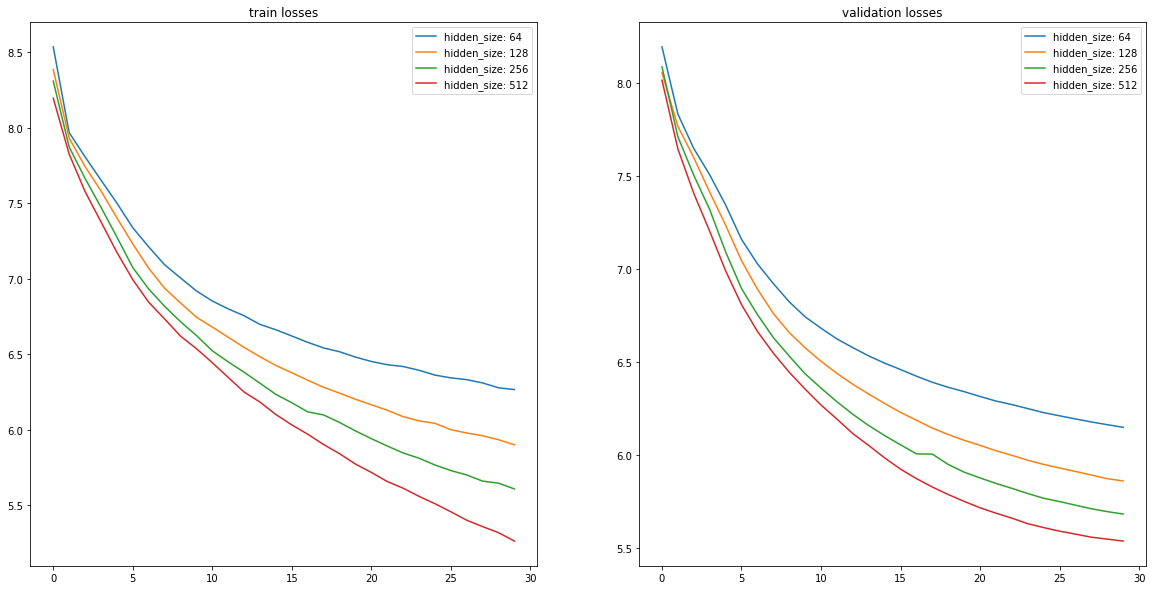

In [ ]:
fig, (train, val) = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 10))

# load the loss cache and plot the curves
for hidden_size in [64, 128, 256, 512]:
    model_dict = torch.load(f'model_lstm_{hidden_size}.pt', map_location = current_device)

    label = f"hidden_size: {hidden_size}"

    for loss in model_dict['losses']:
        # plot training losses
        train.plot(loss[0], label = label)
        # plot validation losses
        val.plot(loss[1], label = label)
    train.legend()
    train.set_title("train losses")
    val.legend()
    val.set_title("validation losses")
    
plt.show()

---
### 2 Learned embeddings (6 pts)
Next you will analyze the word embeddings that the model learns.


#### Utilities

Below is code to use [UMAP](https://umap-learn.readthedocs.io/en/latest/) to find a 2-dimensional representation of a weight matrix, and plot the resulting 2-dimensional points that correspond to certain words.

Use `!pip install umap-learn` to install UMAP.

In [ ]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 88 kB 6.2 MB/s 
     |████████████████████████████████| 1.1 MB 55.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=589a0c4ef9a4b62a7b00ebe70bd6332344a3cc30ee949067bb40e94913a2a1be
  Stored in directory: /root/.cache/pip/wheels/b3/52/a5/1fd9e3e76a7ab34f134c07469cd6f16e27ef3a37aeff1fe821
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55512 sha256=809bcd033835d96b25c6d73280b13c9a7f5fc1116b64cceb4af6cc916a4bfcaa
  Stored in directory: /root/.cache/pip/wheels/19/bc/eb/974072a56a7082a302f8b4be1ad6d21bf5019235c2eff65928
Successfully built umap-learn pynndescent


In [ ]:
%pylab inline 
import umap
import matplotlib.pyplot as plt

def umap_plot(weight_matrix, word_ids, words):
    """Run UMAP on the entire Vxd `weight_matrix` (e.g. model.lookup.weight or model.projection.weight),
    And plot the points corresponding to the given `word_ids`. """
    reduced = umap.UMAP(min_dist=0.0001).fit_transform(weight_matrix.detach().cpu().numpy())
    plt.figure(figsize=(10,10))

    to_plot = reduced[word_ids, :]
    plt.scatter(to_plot[:, 0], to_plot[:, 1])
    for i, word_id in enumerate(word_ids):
        current_point = to_plot[i]
        plt.annotate(words[i], (current_point[0], current_point[1]))

    plt.grid()
    plt.show()

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['split', 'copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


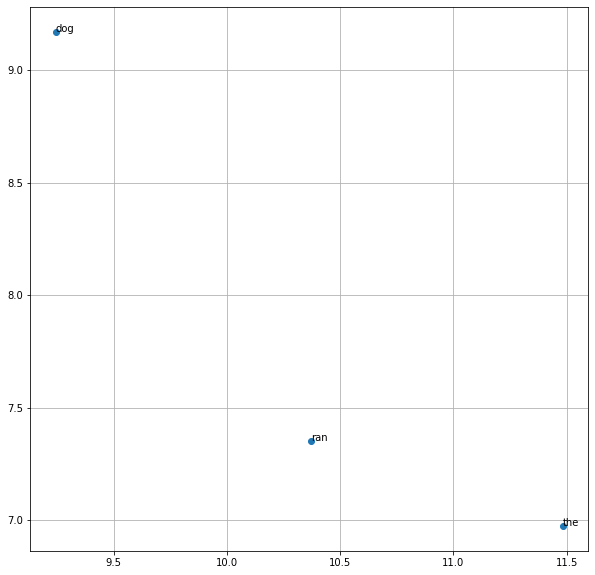

In [ ]:
Vsize = 100                                 # e.g. len(dictionary)
d = 32                                      # e.g. model.lookup.weight.size(1) 
fake_weight_matrix = torch.randn(Vsize, d)  # e.g. model.lookup.weight

words = ['the', 'dog', 'ran']
word_ids = [4, 54, 20]                  # e.g. use dictionary.get_id on a list of words

umap_plot(fake_weight_matrix, word_ids, words)

#### 2.1 Word similarity (3 pts)


In [ ]:
def cosine_similarity(embedding1, embedding2):
    distance1 = np.sqrt(np.sum(embedding1 ** 2))
    distance2 = np.sqrt(np.sum(embedding2 ** 2))
    cosine_similarity = np.dot(embedding1, embedding2)/(distance1 * distance2)
    return cosine_similarity

In [ ]:
best_embedding = best_model.state_dict()['projection.weight']
embedding = best_embedding.detach().cpu().numpy()

In [ ]:
words = ['dog', 'run', 'where', 'quick']

# create a list of integers with the length of wiki_dict
id_lst = [i for i in range(len(wiki_dict))]

# create a list of ids for the four words we want
word_ids = []
for word in words:
    word_id = wiki_dict.get_id(word)
    word_ids.append(word_id)

In [ ]:
closest10 = {}
furthest10 = {}
closest10_ids = []
furthest10_ids = []

# constructing dictionaries with words as keys and 10 closest / furthest words as values
for idx in range(len(word_ids)):
    sim_scores = []
    # create a list of ids for all the other words
    other_ids = [id for id in id_lst if id != word_ids[idx]]
    # compare each word with the rest 
    for other_id in other_ids:
        sim_score = cosine_similarity(embedding[word_ids[idx]], embedding[other_id])
        sim_scores.append(sim_score)
    # sort the cosine similarity scores from highest to lowest
    sorted_scores = sorted(sim_scores, reverse = True)
    # create a list for the closest and furthest 10 similarity scores
    closest10score = sorted_scores[:10]
    furthest10score = sorted_scores[-10:]
    # create a list for the closest and furthest 10 ids
    closest10id = [sim_scores.index(closest10score[i]) for i in range(10)]
    closest10_ids.append(closest10id)
    furthest10id = [sim_scores.index(furthest10score[i]) for i in range(10)]
    furthest10_ids.append(furthest10id)
    # create a list for the closest and furthest 10 words converted from ids
    closest10words = [wiki_dict.get_token(id) for id in closest10id]
    furthest10words = [wiki_dict.get_token(id) for id in furthest10id]
    # adding words as keys and 10 closest / furthest words as values to the dictionary
    closest10[words[idx]] = closest10words
    furthest10[words[idx]] = furthest10words

In [ ]:
# closest ten words for each of the four words: 'dog', 'run', 'where', 'quick'
closest10

{'dog': ['persecution',
  'demonstrating',
  'voice',
  'Levy',
  'remembering',
  'idea',
  'lyrics',
  'ability',
  'concept',
  'Domingo'],
 'run': ['play',
  'match',
  'Nonetheless',
  'release',
  'set',
  'return',
  'win',
  'record',
  'final',
  'score'],
 'where': ['approach',
  'become',
  'synthesizer',
  'but',
  'during',
  'finalized',
  'who',
  'Concept',
  'told',
  'Perhaps'],
 'quick': ['healthy',
  'Spotlight',
  'widths',
  'strong',
  'separate',
  'apart',
  'converge',
  'film',
  'kindergarten',
  'flesh']}

In [ ]:
# furthest ten words for each of the four words: 'dog', 'run', 'where', 'quick'
furthest10

{'dog': ['Victory',
  '2055',
  'Niagara',
  '171',
  'hampering',
  '1943',
  'Castanea',
  'Edinburgh',
  'Avenue',
  '0600'],
 'run': ['undertakings',
  'nuances',
  'ectomycorrhizae',
  'decency',
  'clearer',
  'the',
  'electrical',
  'Kirkland',
  'Orsini',
  'rations'],
 'where': ['euphoria',
  'confronted',
  'Elkton',
  'Akropolites',
  'superintendent',
  'Normandy',
  'cofferdam',
  'the',
  '050',
  'Martindale'],
 'quick': ['Grey',
  'piracy',
  'Su',
  'Digg',
  'Tour',
  'pirates',
  'starts',
  'Ruppert',
  'should',
  'alarms']}

#### 2.2 UMAP (3 pts)

In [ ]:
allclosest10words = []
for sublist in [words for words in closest10.values()]:
    for word in sublist:
        allclosest10words.append(word)

allfurthest10words = []
for sublist in [words for words in furthest10.values()]:
    for word in sublist:
        allfurthest10words.append(word)

all_closest10_ids = []
for sublist in closest10_ids:
    for id in sublist:
        all_closest10_ids.append(id)

all_furthest10_ids = []
for sublist in furthest10_ids:
    for id in sublist:
        all_furthest10_ids.append(id)

all_words = words + allclosest10words + allfurthest10words
all_word_ids = word_ids + all_closest10_ids + all_furthest10_ids

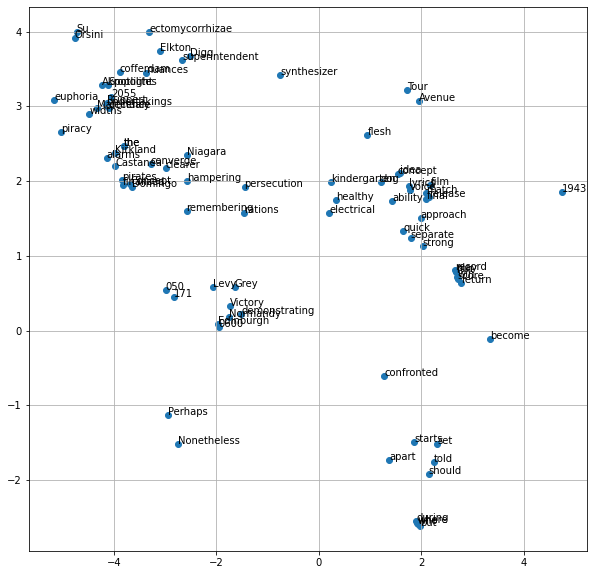

In [ ]:
umap_plot(best_embedding, all_word_ids, all_words)